In [98]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from networkgen import Network, NetworkType
from model import OpinionModel, Opinion

In [112]:
#n, p = 100, 0.3 # DEFAULT
#n, k, p = 100, 5, 0.5 # SMALLWORLD
l, k = 10, 5 # CAVEMAN
n = l*k
network_params = (l, k)
initial_believers = 0.2
p_opinion_change = 0.15
model = OpinionModel(n, initial_believers, p_opinion_change, network_type=NetworkType.CAVEMAN, network_params=network_params)

In [114]:
model.run(40)

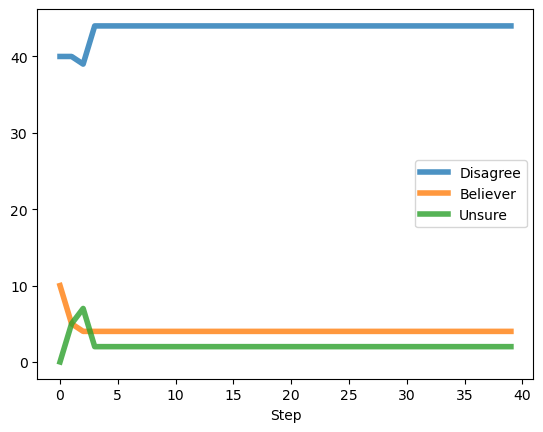

In [115]:
def sum_agents(model):

    agent_data = model.data_collector.get_agent_vars_dataframe()
    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
    # relabel
    labels = ['Disagree','Believer','Unsure']
    agents_summed.columns = labels[:len(agents_summed.columns)]
    return agents_summed

def plot_agent_opinion(model):
    steps = model.schedule.steps
    X = sum_agents(model)
    X.plot(lw = 4, alpha = 0.8)

plot_agent_opinion(model)

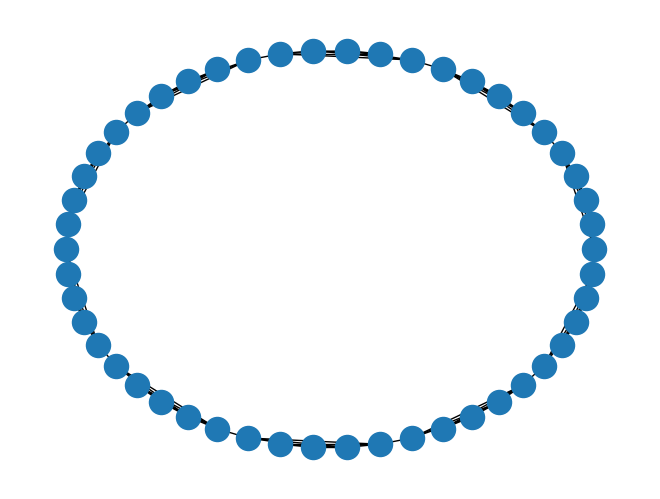

In [94]:
Network.visualize(NetworkType.SMALLWORLD, model.network)

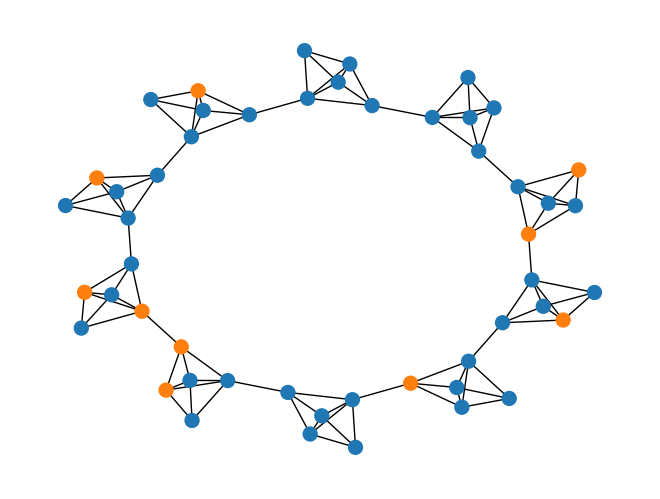

In [113]:
color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

states = [int(i.state) for i in model.grid.get_all_cell_contents()]

colors = [color_code(i) for i in states]

nx.draw_kamada_kawai(model.network, node_size = 100, edge_color = 'black', node_color = colors)

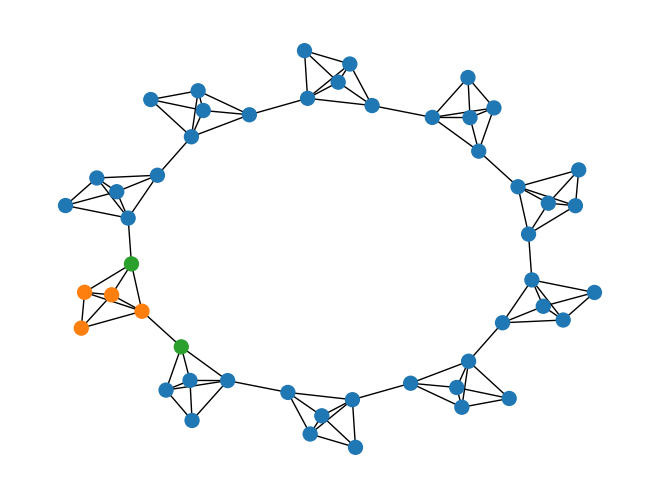

In [116]:
color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

states = [int(i.state) for i in model.grid.get_all_cell_contents()]

colors = [color_code(i) for i in states]

nx.draw_kamada_kawai(model.network, node_size = 100, edge_color = 'black', node_color = colors)